In [1]:
import lenstronomy.Util.simulation_util as sim_util
import lenstronomy.Util.image_util as image_util
from lenstronomy.Util import param_util
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy.constants import c, G



In [2]:
# Observation 
background_rms = 0.5        # Background noise per pixel
exp_time = 100              # Exposure time (arbitrary units)
numPix = 100                # Number of pixels
deltaPix = 0.05             # Pixel size in arcsec

# PSF specification
fwhm = 0.1
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
kwargs_psf = {
    "psf_type": "GAUSSIAN",
    "fwhm": fwhm,
    "pixel_size": deltaPix,
    "truncation": 5
}
psf_class = PSF(**kwargs_psf)

# Lens Parameters 
f = 0.7
sigmav = 200.
pa = np.pi / 4.0            # Position angle (radians)
zl = 0.3                    # Lens redshift
zs = 1.5                    # Source redshift

# Cosmology and Einstein Radius Calculation
co = FlatLambdaCDM(H0=70, Om0=0.3)
dl = co.angular_diameter_distance(zl)
ds = co.angular_diameter_distance(zs)
dls = co.angular_diameter_distance_z1z2(zl, zs)

thetaE = 1e6 * (4.0 * np.pi * sigmav**2 / c**2 * dls / ds * 180.0 / np.pi * 3600.0).value

# Eccentricity computation
e1 = (1 - f) / (1 + f) * np.cos(-2 * pa)
e2 = (1 - f) / (1 + f) * np.sin(-2 * pa)

lens_model_list = ["SIE"]
kwargs_sie = {
    "theta_E": thetaE,
    "center_x": 0,
    "center_y": 0,
    "e1": e1,
    "e2": e2
}
kwargs_lens = [kwargs_sie]
lens_model_class = LensModel(lens_model_list=lens_model_list)


# Lens light model
lens_light_model_list = ["SERSIC_ELLIPSE"]
kwargs_sersic = {
    "amp": 3500,
    "R_sersic": 2.,
    "n_sersic": 4,
    "center_x": 0,
    "center_y": 0,
    "e1": e1,
    "e2": e2
}
kwargs_lens_light = [kwargs_sersic]
lens_light_model_class = LightModel(light_model_list=lens_light_model_list)

# Source light model
source_model_list = ["SERSIC_ELLIPSE"]
ra_source, dec_source = -0.1 * thetaE, thetaE
kwargs_sersic_ellipse = {
    "amp": 4000.,
    "R_sersic": .1,
    "n_sersic": 3,
    "center_x": ra_source,
    "center_y": dec_source,
    "e1": 0.1,
    "e2": 0.01
}
kwargs_source = [kwargs_sersic_ellipse]
source_model_class = LightModel(light_model_list=source_model_list)

# Lens Equation Solver 
lensEquationSolver = LensEquationSolver(lens_model_class)
x_image, y_image = lensEquationSolver.image_position_from_source(
    ra_source,
    dec_source,
    kwargs_lens,
    min_distance=deltaPix,
    search_window=numPix * deltaPix,
    precision_limit=1e-10,
    num_iter_max=100,
    arrival_time_sort=True,
    initial_guess_cut=True,
    verbose=False,
    x_center=0,
    y_center=0,
    num_random=0,
    non_linear=False,
    magnification_limit=None
)

# Magnification and Point Source 
mag = lens_model_class.magnification(x_image, y_image, kwargs=kwargs_lens)
mag = np.abs(mag)  # Ignore sign

# Perturbed magnifications (e.g. microlensing noise)
mag_pert = np.random.normal(mag, 0.5, len(mag))

# Quasar positions in lens plane
kwargs_ps = [{
    "ra_image": x_image,
    "dec_image": y_image,
    "point_amp": mag[i]
} for i in range(len(mag))]

point_source_list = ["LENSED_POSITION"]
point_source_class = PointSource(point_source_type_list=point_source_list, fixed_magnification_list=[False])

# Simulate Image 
kwargs_numerics = {
    "supersampling_factor": 1,
    "supersampling_convolution": False
}

imageModel = ImageModel(
    data_class,
    psf_class,
    lens_model_class,
    source_model_class,
    lens_light_model_class,
    point_source_class,
    kwargs_numerics=kwargs_numerics
)

image_sim = imageModel.image(
    kwargs_lens,
    kwargs_source,
    kwargs_lens_light,
    kwargs_ps
)

# Add noise and background
poisson = image_util.add_poisson(image_sim, exp_time=exp_time)
bkg = image_util.add_background(image_sim, sigma_bkd=background_rms)
image_sim = image_sim + bkg + poisson



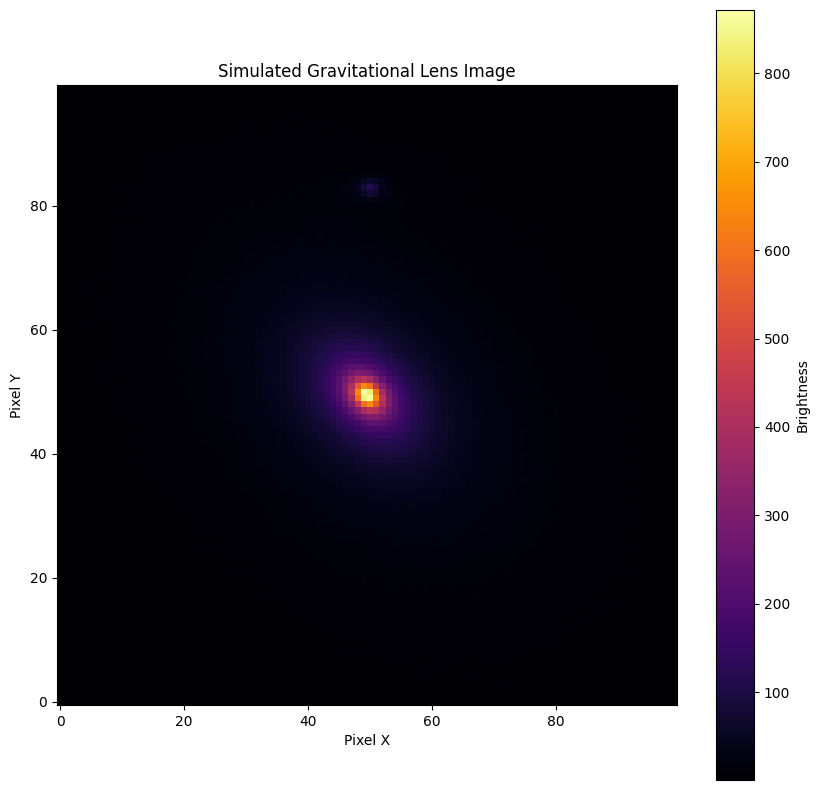

In [3]:
#  Visualization 
plt.figure(figsize=(10, 10))
plt.imshow(image_sim, origin='lower', cmap='inferno')
plt.colorbar(label='Brightness')
plt.title('Simulated Gravitational Lens Image')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')
plt.show()
